# Оценка результатов A/B тестирования

## Описание проекта

**Цель** исследования - исследовать корректность и провести оценку результатов A/B-теста.

**Ход исследования:**
* Выполнить предобработку данных
* Оценить корректность проведения теста:
    - Соответствие данных требованиям технического задания. Проверить корректность всех пунктов технического задания.
    - Время проведения теста. Убедиться, что оно не совпадает с маркетинговыми и другими активностями.
    - Аудитория теста. Удостовериться, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверить равномерность распределения по тестовым группам и правильность их формирования.
* Провести исследовательский анализ данных:
    - Количество событий на пользователя одинаково распределены в выборках?
    - Как число событий в выборках распределено по дням?
    - Как меняется конверсия в воронке в выборках на разных этапах?
    - Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
* Оценить результаты A/B-тестирования
    - Что можно сказать про результаты A/В-тестирования?
    - Проверьте статистическую разницу долей z-критерием.
* Сформулировать выводы

**Техническое задание**

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

**Описание данных**

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

## Загрузка и знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import math as mth

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [2]:
try:
    m_events, n_users, events, ab_users= (
        pd.read_csv('ab_project_marketing_events.csv'),
        pd.read_csv('final_ab_new_users.csv'),
        pd.read_csv('final_ab_events.csv'),
        pd.read_csv('final_ab_participants.csv')
    )
except:
    m_events, n_users, events, ab_users= (
        pd.read_csv('/datasets/ab_project_marketing_events.csv'),
        pd.read_csv('/datasets/final_ab_new_users.csv'),
        pd.read_csv('/datasets/final_ab_events.csv'),
        pd.read_csv('/datasets/final_ab_participants.csv') 
    )

In [3]:
display(m_events.sample(3))
display(n_users.sample(3))
display(events.sample(3))
display(ab_users.sample(3))

,name,regions,start_dt,finish_dt
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16


,user_id,first_date,region,device
53945,F9F9469C2F547188,2020-12-13,CIS,Android
21568,F4EC4110EB5ACF1D,2020-12-15,EU,iPhone
44156,50826DF7F032ACCE,2020-12-18,EU,iPhone


,user_id,event_dt,event_name,details
67535,E3489214C951A58C,2020-12-09 13:55:25,product_cart,NaN
149693,1FB147305F651265,2020-12-13 12:36:16,product_page,NaN
295543,45CBAC51835124DF,2020-12-14 14:07:00,login,NaN


,user_id,group,ab_test
12584,7591676C34F21ACD,B,interface_eu_test
15395,7768F84153D017E9,B,interface_eu_test
13684,1C7D23927835213F,B,interface_eu_test


In [4]:
m_events.info(), n_users.info(), events.info(), ab_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  obj

(None, None, None, None)

Пропуски есть только в столбце `details` в датасете `events`.   
Даты во всех датасетах в формате `object`, необходимо будет перевести в `datetime`.

## Предобработка данных

### дубликаты

Проверим датасеты на наличие явных дубликатов

In [5]:
m_events.duplicated().sum(), n_users.duplicated().sum(), events.duplicated().sum(), ab_users.duplicated().sum()

(0, 0, 0, 0)

Проверим категориальные данные на наличие неявных дубликатов

In [6]:
m_events['name'].unique(), m_events['regions'].unique()

(array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
        "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
        'Black Friday Ads Campaign', 'Chinese New Year Promo',
        'Labor day (May 1st) Ads Campaign',
        "International Women's Day Promo",
        'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
        'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
        'Chinese Moon Festival'], dtype=object),
 array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
        'EU, CIS, APAC', 'CIS'], dtype=object))

In [7]:
n_users['region'].unique(), n_users['device'].unique()

(array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object),
 array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object))

In [8]:
events['event_name'].unique(), events['details'].unique()

(array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object),
 array([ 99.99,   9.99,   4.99, 499.99,    nan]))

In [9]:
ab_users['group'].unique(), ab_users['ab_test'].unique()

(array(['A', 'B'], dtype=object),
 array(['recommender_system_test', 'interface_eu_test'], dtype=object))

### формат данных

Изменим формат времени в датасетах на `datetime`

In [10]:
m_events['start_dt']= pd.to_datetime(m_events['start_dt']) 
m_events['finish_dt']= pd.to_datetime(m_events['finish_dt'])
n_users['first_date']= pd.to_datetime(n_users['first_date'])
events['event_dt']= pd.to_datetime(events['event_dt'])

In [11]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


### пропуски

На этапе знакомства с данными мы выяснили, что пропуски есть только в датасете `events` в столбце `details` (дополнительные данные о событии). В качестве уникальных значений столбца представлены только цифры, то есть цены. То есть, вероятнее всего, пропуски связаны с самим событием.

In [12]:
print('Количество пропущенных значений =', events['details'].isna().sum())
print('Количество заполненных значений =', events['details'].notna().sum())

Количество пропущенных значений = 377577
Количество заполненных значений = 62740


In [13]:
events.groupby('event_name').agg({'details':'count'})

,details
event_name,
login,0
product_cart,0
product_page,0
purchase,62740


Пропущенные значения отсутствуют только при событии покупка, для остальных значений событий нет никакой дополнительной информации. Удалять или заполнять их не требуется.

## Проверка ТЗ

Прежде всего, необходимо объединить датафреймы `n_users`, `events` и `ab_users` в один.

Ключевым является датасет с участниками тестов, поэтому присоединять будем по столбцу `user_id` таким образом, чтобы отсечь нерелевантных юзеров из других датасетов.

In [14]:
ab_users['user_id'].nunique(), events['user_id'].nunique(), n_users['user_id'].nunique()

(16666, 58703, 61733)

In [15]:
df= ab_users.merge(events, on= 'user_id', how= 'left')
df['user_id'].nunique()

16666

In [16]:
df= df.merge(n_users, on= 'user_id', how= 'left')
df['user_id'].nunique()

16666

In [17]:
df.sample(2)

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
105099,9580270116FFFADA,A,interface_eu_test,2020-12-24 17:19:47,purchase,9.99,2020-12-14,EU,PC
89584,B6E9C41B7467AFB6,A,interface_eu_test,2020-12-22 17:53:02,product_cart,NaN,2020-12-16,EU,Mac


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110368 entries, 0 to 110367
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     110368 non-null  object        
 1   group       110368 non-null  object        
 2   ab_test     110368 non-null  object        
 3   event_dt    106625 non-null  datetime64[ns]
 4   event_name  106625 non-null  object        
 5   details     15416 non-null   float64       
 6   first_date  110368 non-null  datetime64[ns]
 7   region      110368 non-null  object        
 8   device      110368 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 8.4+ MB


После объединения датафреймов появились новые пропущенные значения в столбцах `event_dt` и `event_name`. Это пользователи зарегистрировавшиеся в системе, но не совершавшие никаких действий.

### Анализ новых пропусков

Прежде, чем проводить анализ пропущенных значений, посмотрим, есть ли пользователи, принимающие участие в обоих тестах.

In [19]:
df.groupby('user_id').agg({'ab_test':'nunique'}).query('ab_test> 1').count()

ab_test    1602
dtype: int64

1602 пользователя принимает участие в обоих тестах, позже придется их убрать для корректного анализа результатов интересующего нас теста.

Но среди них, вероятно, есть пользователи, которые, участвуя в двух тестах, могут состоять в контрольной группе А для каждого из тестов. Такие пользователи не буду влиять на анализ результатов тестирования.   
Посмотрим, есть ли такие.

In [20]:
(df.query('group != "B"')
 .groupby('user_id').agg({'ab_test':'nunique'})
 .query('ab_test> 1').count())

ab_test    482
dtype: int64

482 пользователя участвуют в двух тестах и находятся в А группах.

Создадим новый датафрейм в котором будут пользователи участвующие только в одном тесте.

In [21]:
#переменная для сохранения А-А пользователей
double_AA_users= (
    df.query('group != "B"')
    .groupby('user_id', as_index= False)
    .agg({'ab_test':'nunique'})
    .query('ab_test> 1')['user_id'])

double_AA_users.count()

482

In [22]:
# переменная для отсечения пользователей из двух групп
double_users= df.groupby('user_id', as_index= False).agg({'ab_test':'nunique'}).query('ab_test> 1')
double_users= double_users.query('user_id not in @double_AA_users')['user_id']

double_users.count()

1120

In [23]:
df_1_test= df.query('user_id not in @double_users')

In [24]:
df_1_test['user_id'].nunique()

15546

In [25]:
df_1_test.sample(2)

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
22145,23F246A7F4388473,A,recommender_system_test,2020-12-17 21:33:49,login,NaN,2020-12-17,EU,Mac
91354,2D30AA371461F7EA,B,interface_eu_test,2020-12-17 15:25:58,purchase,4.99,2020-12-14,EU,Android


In [26]:
# датасет уникальных юзеров участвующих в одном тесте, либо в двух А-А тестах для анализа пропусков
df_1_test_nans= (
    df_1_test.groupby(['user_id', 'ab_test'], as_index= False)
    .agg({
        'group': 'max',
        'region': 'max',
        'device': 'max',
        'event_dt': 'max',
         'first_date': 'max'
    })
)

Напишем функцию для расчета доли пропусков по категориям.

In [27]:
def nan_rate_cols_test (df):
    print('------------')
    x=['group', 'region', 'device', 'first_date'] #рассматриваемые категории 
    
    for c in x:
        nans= df.groupby([c]).agg({'user_id': 'count', 'event_dt': 'count'})
        nans['nan_rate_%']= round((1-nans['event_dt']/nans['user_id'])*100,2) #расчет доли
        print('столбец', c)
        print('------------')
        display(nans)
        print('------------')

In [28]:
nan_rate_cols_test(df_1_test_nans.query('ab_test != "interface_eu_test" '))

------------
столбец group
------------


,user_id,event_dt,nan_rate_%
group,,,
A,3385,2422,28.45
B,2196,706,67.85


------------
столбец region
------------


,user_id,event_dt,nan_rate_%
region,,,
APAC,72,45,37.50
CIS,55,30,45.45
EU,5231,2934,43.91
N.America,223,119,46.64


------------
столбец device
------------


,user_id,event_dt,nan_rate_%
device,,,
Android,2514,1393,44.59
Mac,499,286,42.69
PC,1410,803,43.05
iPhone,1158,646,44.21


------------
столбец first_date
------------


,user_id,event_dt,nan_rate_%
first_date,,,
2020-12-07,525,273,48.00
2020-12-08,296,122,58.78
2020-12-09,204,129,36.76
2020-12-10,330,86,73.94
2020-12-11,234,97,58.55
2020-12-12,414,98,76.33
2020-12-13,495,61,87.68
2020-12-14,556,401,27.88
2020-12-15,288,206,28.47


------------


Среди пользователей участвующих в тесте `recommender_system_test`, в распределении по тестовым группам, большая часть неактивных клиентов находится в тестовой группе `B` - 68%, в то время как в контрольной группе `A` - 28%.  По остальным категориям пользователи распределены относительно равномерно - 40-45%.

In [29]:
nan_rate_cols_test(df_1_test_nans.query('ab_test == "interface_eu_test"'))

------------
столбец group
------------


,user_id,event_dt,nan_rate_%
group,,,
A,5494,5351,2.60
B,4953,4952,0.02


------------
столбец region
------------


,user_id,event_dt,nan_rate_%
region,,,
EU,10447,10303,1.38


------------
столбец device
------------


,user_id,event_dt,nan_rate_%
device,,,
Android,4703,4627,1.62
Mac,1073,1060,1.21
PC,2649,2614,1.32
iPhone,2022,2002,0.99


------------
столбец first_date
------------


,user_id,event_dt,nan_rate_%
first_date,,,
2020-12-07,911,885,2.85
2020-12-08,544,531,2.39
2020-12-09,372,363,2.42
2020-12-10,490,470,4.08
2020-12-11,407,397,2.46
2020-12-12,725,704,2.90
2020-12-13,788,743,5.71
2020-12-14,936,936,0.00
2020-12-15,518,518,0.00


------------


Неактивных пользователей участвующих в тесте `interface_eu_test` не более 3% в каждой категории, в распределении по времени после 13 декабря среди пользователей ни одного неактивного.

Выявить закономерности не получается - колоссальная разница даже среди участников контрольных групп, которых изменения не касаются -  в `recommender_system_test` - 28% неактивных пользователей, в `interface_eu_test` - 3%.   
Если рассматривать пользователей без событий в разрезе региона `EU`, то среди участников `recommender_system_test` таких 44%, среди `interface_eu_test` - 1,4%.   
В группе `interface_eu_test` после 13 декабря нет ни одного неактивного пользователя, в `recommender_system_test` - особых разлиичий нет.

Поскольку пользователи не совершающие никаких действий никак не пригодятся для последующего анализа А/Б теста, придется их удалить.

In [30]:
df_1_test= df_1_test[df_1_test['event_dt'].notna()]
df_1_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99661 entries, 0 to 110367
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     99661 non-null  object        
 1   group       99661 non-null  object        
 2   ab_test     99661 non-null  object        
 3   event_dt    99661 non-null  datetime64[ns]
 4   event_name  99661 non-null  object        
 5   details     14492 non-null  float64       
 6   first_date  99661 non-null  datetime64[ns]
 7   region      99661 non-null  object        
 8   device      99661 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 7.6+ MB


Проверим пересечения внутри теста

In [31]:
(
df_1_test
    .groupby('user_id')
    .agg({'group' : 'nunique'})
    .query('group>1')
)

,group
user_id,


Пересечений внутри теста нет

### Корректность

Далее по пунктам проверим техническое задание на корректность.

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

Создадим датафрейм, в котором будут пользователи, участвовавшие в исследуемомтесте - `recommender_system_test`.

In [32]:
df_rec= df_1_test.query('ab_test== "recommender_system_test"').drop(columns= 'ab_test')
display(df_rec.sample(2))
df_rec.shape

,user_id,group,event_dt,event_name,details,first_date,region,device
26402,A47A3F447566B4FB,A,2020-12-29 08:33:21,login,NaN,2020-12-19,N.America,Android
3771,BE52857ABCAD4C9B,A,2020-12-18 04:47:25,product_page,NaN,2020-12-18,EU,PC


(21216, 8)

Согласно ТЗ:
* дата регистрации пользователя должна быть в пределах 2020-12-07 - 2020-12-21
* последнее действие пользователя должно быть не позднее 2021-01-04
* лайфтайм пользователя не должен превышать 14 дней
* 15% пользователей должны быть из EU
* количество участников теста - ~6000

In [33]:
df_rec.query('first_date < "2020-12-07" or first_date > "2020-12-21"')

,user_id,group,event_dt,event_name,details,first_date,region,device


С регистрацией пользователей все в порядке. Новые пользователи в границах проведения теста.

In [34]:
df_rec.query('event_dt > "2021-01-04"')

,user_id,group,event_dt,event_name,details,first_date,region,device


С последними действиями пользователей тоже все в порядке.

___

Согласно тз, количество пользователей в исследуемом тесте должно составлять 15% от количества новых пользователей из `EU` зарегистрированных 

Проверим наш датафрейм со всеми новыми пользователями на соответствие временному периоду

In [35]:
df.query('first_date < "2020-12-07" or first_date > "2020-12-21"')

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
27724,D4E530F6595A05A3,A,interface_eu_test,2020-12-22 06:01:01,product_cart,NaN,2020-12-22,EU,Android
27725,D4E530F6595A05A3,A,interface_eu_test,2020-12-25 18:39:01,product_cart,NaN,2020-12-22,EU,Android
27726,D4E530F6595A05A3,A,interface_eu_test,2020-12-26 09:31:53,product_cart,NaN,2020-12-22,EU,Android
27727,D4E530F6595A05A3,A,interface_eu_test,2020-12-29 23:35:45,product_cart,NaN,2020-12-22,EU,Android
27728,D4E530F6595A05A3,A,interface_eu_test,2020-12-22 06:00:57,login,NaN,2020-12-22,EU,Android
...,...,...,...,...,...,...,...,...,...
110256,4E72793CE1C61E8D,A,interface_eu_test,2020-12-28 13:16:26,product_page,NaN,2020-12-22,EU,iPhone
110257,4E72793CE1C61E8D,A,interface_eu_test,2020-12-22 13:08:15,login,NaN,2020-12-22,EU,iPhone
110258,4E72793CE1C61E8D,A,interface_eu_test,2020-12-23 01:15:14,login,NaN,2020-12-22,EU,iPhone
110259,4E72793CE1C61E8D,A,interface_eu_test,2020-12-26 00:51:20,login,NaN,2020-12-22,EU,iPhone


In [36]:
eu_users = df.query('(first_date >= "2020-12-07" and first_date <= "2020-12-21") and region == "EU"')
eu_users[eu_users['ab_test']== "recommender_system_test"]['user_id']

0        D1ABA3E2887B6A73
1        D1ABA3E2887B6A73
2        D1ABA3E2887B6A73
3        D1ABA3E2887B6A73
4        D1ABA3E2887B6A73
               ...       
26285    80712ED4EA1B52A5
26286    80712ED4EA1B52A5
26287    80712ED4EA1B52A5
26288    80712ED4EA1B52A5
26289    80712ED4EA1B52A5
Name: user_id, Length: 26290, dtype: object

In [37]:
n_users.query('first_date <= "2020-12-21" and region == "EU"')['user_id']

0        D72A72121175D8BE
2        2E1BF1D4C37EA01F
3        50734A22C0C63768
7        8942E64218C9A1ED
9        FFCEA1179C253104
               ...       
61728    1DB53B933257165D
61729    538643EB4527ED03
61730    7ADEE837D5D8CBBD
61731    1C7D23927835213F
61732    8F04273BB2860229
Name: user_id, Length: 42340, dtype: object

In [38]:
(eu_users[eu_users['ab_test']== "recommender_system_test"]['user_id'].nunique()
/n_users.query('first_date <= "2020-12-21" and region == "EU"')['user_id'].nunique())

0.15

Расчет показал, что наша аудитория - 15% новых пользователей из региона EU, что полностью согласуется с ТЗ.

### Лайфтайм

Проверим лайфтайм пользователей.

In [39]:
df_rec.sample(1)

,user_id,group,event_dt,event_name,details,first_date,region,device
15230,5B5F8713DF915802,A,2020-12-22 12:25:44,login,NaN,2020-12-21,EU,Android


In [40]:
date_check= df_rec.groupby('user_id', as_index= False).agg({'event_dt': 'last', 'first_date': 'max'})
date_check['event_dt']= pd.to_datetime(date_check['event_dt']).dt.date
date_check['event_dt']= pd.to_datetime(date_check['event_dt']).dt.normalize()
date_check.sample(2)

,user_id,event_dt,first_date
144,0DC63E84277804EC,2020-12-14,2020-12-14
2197,B28720DBB0468944,2020-12-21,2020-12-17


In [41]:
date_check['days_diff']= (date_check['event_dt']-date_check['first_date']).dt.days
date_check.sample(1)

,user_id,event_dt,first_date,days_diff
682,38C10366AB1B0A90,2020-12-19,2020-12-14,5


In [42]:
date_check.query('days_diff > 14')

,user_id,event_dt,first_date,days_diff
13,015CCC27BDB640E1,2020-12-24,2020-12-09,15
16,016F758EB5C5A5DA,2020-12-29,2020-12-13,16
17,0178FA423606B54B,2020-12-28,2020-12-08,20
25,021E3EC8A37EE2E3,2020-12-29,2020-12-07,22
57,053FB26D6D49EDDC,2020-12-25,2020-12-10,15
...,...,...,...,...
3084,FCF9CA847EFA5A92,2020-12-28,2020-12-07,21
3086,FD11BEB17BD1E5F1,2020-12-28,2020-12-09,19
3091,FD38A6D8AF786363,2020-12-24,2020-12-08,16
3098,FDC4F5414D325E59,2020-12-29,2020-12-09,20


У 228 пользователей промежуток между регистрацией и последним действием составляет более 14 дней. В соответствии с тз, придется их убрать.

In [43]:
users_big_lifetime= date_check.query('days_diff > 14')['user_id']

In [44]:
df_rec= df_rec.query('user_id not in @users_big_lifetime')

### Пересечение с событиями

Посмотрим, есть ли события совпадающие с временем проведения теста

In [45]:
m_events.query('start_dt >= "2020-12-07" and finish_dt <= "2021-01-04"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03


Есть только одно событие совпадающее с проведением теста.

### Количество пользователей

Согласно тз, количество участников в тесте должно составлять 6000 пользователей.

In [46]:
df_rec['user_id'].nunique()

2900

In [47]:
df_rec.sample(2)

,user_id,group,event_dt,event_name,details,first_date,region,device
19232,CD77B10F620BEABA,A,2020-12-26 03:28:29,login,NaN,2020-12-21,EU,iPhone
14945,C890B90703F73F15,A,2020-12-25 02:21:14,product_cart,NaN,2020-12-21,EU,iPhone


После всех проверок и удалений нерелевантных пользователей у нас осталось всего 2900 пользователей.

In [48]:
df_rec.groupby('group', as_index= False).agg({'user_id': 'nunique'})

,group,user_id
0,A,2280
1,B,620


Если учесть, что базовая конверсия - 50%, минимальный обнаруживаемый эффект - 10%, при статистической мощности 80% и уровне значимости - 5%, размер выборки составляет 390 человек, что вполне удовлетворяет нашим данным (2280- группа A, 620 человек - группа - B)

Посчитаем равномерность распределения пользователей в группах 

In [49]:
ab_rel = (df_rec
          .groupby('group')
          .agg({'user_id': 'nunique'}))

round(ab_rel['user_id'][0]/ab_rel['user_id'][1],2)

3.68

Пользователи в группах распределены неравномерно - в контрольной группе в 3.7 раз больше пользователей, чем в тестовой.

### Конверсия

Согласно тз, ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
* конверсии в просмотр карточек товаров — событие `product_page`,
* просмотры корзины — `product_cart`,
* покупки — `purchase`.

Построим воронки

In [50]:
funnel_A= (
    df_rec.query('group == "A"')
    .groupby('event_name', as_index= False)
    .agg({'user_id': 'nunique'})
    .rename(columns= {'user_id': 'users'})
    .sort_values(by= 'users', ascending= False)
)
funnel_B= (
    df_rec.query('group == "B"')
    .groupby('event_name', as_index= False)
    .agg({'user_id': 'nunique'})
    .rename(columns= {'user_id': 'users'})
    .sort_values(by= 'users', ascending= False)
)
display(funnel_A)
display(funnel_B)

,event_name,users
0,login,2280
2,product_page,1478
3,purchase,735
1,product_cart,695


,event_name,users
0,login,620
2,product_page,349
3,purchase,176
1,product_cart,175


Теоретически, порядок действий пользователя должен быть следующий: логин-просмотр продукта-добавление продукта-покупка.   
Однако, согласно расчетам, некоторые пользователи сразу переходят к стадии покупки, минуя стадию добавления в корзину. Вероятно, на сайте есть возможность купить товар на странице товара, не добавляя его в корзину.

In [51]:
funnel_A['conversion']= round((funnel_A['users']/df_rec.query('group == "A"')['user_id'].nunique())*100,2)
funnel_B['conversion']= round((funnel_B['users']/df_rec.query('group == "B"')['user_id'].nunique())*100,2)

In [52]:
funnel_A['step_conversion'] = round(
    (funnel_A['conversion'] / funnel_A['conversion'].shift())*100, 2
)

funnel_B['step_conversion'] = round(
    (funnel_B['conversion'] / funnel_B['conversion'].shift())*100, 2
)

In [53]:
display(funnel_A)
display(funnel_B)

,event_name,users,conversion,step_conversion
0,login,2280,100.00,NaN
2,product_page,1478,64.82,64.82
3,purchase,735,32.24,49.74
1,product_cart,695,30.48,94.54


,event_name,users,conversion,step_conversion
0,login,620,100.00,NaN
2,product_page,349,56.29,56.29
3,purchase,176,28.39,50.44
1,product_cart,175,28.23,99.44


In [54]:
# Разница в конверсии в между группами A и B
display(funnel_A['conversion']- funnel_B['conversion'])

0    0.00
2    8.53
3    3.85
1    2.25
Name: conversion, dtype: float64

Разница в конверсии между контрольной и тестовой группами менее 10%. У тестовой группы конверсия меньше, чем у контрольной.

### Вывод

Проверка технического задания выявила следующие расхождения:
* После всех проверок и удалений нерелевантных пользователей у нас осталось всего 2900 пользователей, вместо запланированных 6000
* Пользователи в группах распределены неравномерно - в контрольной группе в 3.7 раз больше пользователей, чем в тестовой.
* Разница в конверсии между контрольной и тестовой группами менее ожидаемых 10%. У тестовой группы конверсия меньше, чем у контрольной.

## Исследовательский анализ данных

- Количество событий на пользователя одинаково распределены в выборках?
- Как число событий в выборках распределено по дням?
- Как меняется конверсия в воронке в выборках на разных этапах?
- Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?

___

*Количество событий на пользователя одинаково распределены в выборках?*

In [55]:
user_event= (df_rec
             .groupby(['group', 'event_name'])
             .agg(count= ('user_id', 'count')
                  , nunique=('user_id', 'nunique')))
user_event['rate']= round(user_event['count']/user_event['nunique'],2)
user_event

count  nunique  rate
group event_name                        
A     login          7041     2280  3.09
      product_cart   2155      695  3.10
      product_page   4557     1478  3.08
      purchase       2211      735  3.01
B     login          1641      620  2.65
      product_cart    443      175  2.53
      product_page    869      349  2.49
      purchase        434      176  2.47

В целом, количество событий на пользователя распределено относительно равномерно.

In [56]:
event_by_user= df_rec.groupby('user_id', as_index= False).agg({'event_name':'count'})
event_by_user['event_name'].mean()

6.672758620689655

В среднем на одного пользователя приходится 6.67 событий.

___

*Как число событий в выборках распределено по дням?*

In [57]:
df_rec['event_day']= df_rec['event_dt'].dt.day
df_rec['event_day']= df_rec['event_day'].astype(str).replace({'7':'07','8':'08','9':'09'})

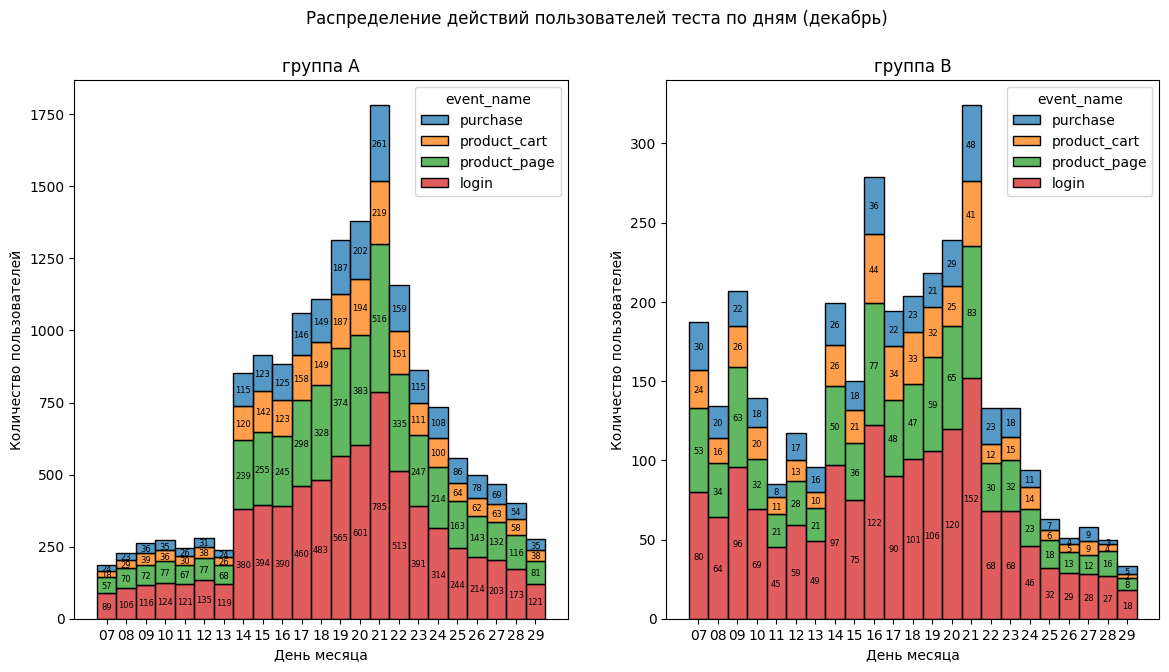

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
axes= axes.flatten()
sns.axes_style('dark')
fig.suptitle('Распределение действий пользователей теста по дням (декабрь) ')

ax1= sns.histplot(ax= axes[0],
                 data= df_rec.query('group== "A"')
                 .sort_values(by= 'event_day'), 
                 x= 'event_day',
                 hue= 'event_name',
                 multiple= 'stack',
                 hue_order= ['purchase', 'product_cart', 'product_page', 'login'])
axes[0].title.set_text('группа A')
for c in ax1.containers:
    ax1.bar_label(c, label_type= 'center', color= 'black', fontsize= 6, padding= -1)

ax2=sns.histplot(ax= axes[1],
                 data= df_rec.query('group== "B"')
                 .sort_values(by= 'event_day'), 
                 x= 'event_day',
                 hue= 'event_name',
                 multiple= 'stack',
                 hue_order= ['purchase', 'product_cart', 'product_page', 'login'])
axes[1].title.set_text('группа B')
for c in ax2.containers:
    ax2.bar_label(c, label_type= 'center', color= 'black', fontsize= 6, padding= -1)
    
for c in range(2):
    axes[c].set_xlabel('День месяца')
    axes[c].set_ylabel('Количество пользователей')

В контрольной группе А число событий резко начинает расти после 13 декабря, пик - 21 декабря.   
В тестовой группе B изначально число событий имеет средние значения, к 13 числу снижаюся и дальше постепенно растут до пика 21 декабря. В отличие от контрольной группы, резких скачков тут не наблюдается.

___

*Как меняется конверсия в воронке в выборках на разных этапах?*

На этапе проверки ТЗ уже сравнивались воронки двух групп.

In [59]:
print('Воронка контрольной группы')
display(funnel_A)
print('___________________________')
print('Воронка тестовой группы')
display(funnel_B)

Воронка контрольной группы


,event_name,users,conversion,step_conversion
0,login,2280,100.00,NaN
2,product_page,1478,64.82,64.82
3,purchase,735,32.24,49.74
1,product_cart,695,30.48,94.54


___________________________
Воронка тестовой группы


,event_name,users,conversion,step_conversion
0,login,620,100.00,NaN
2,product_page,349,56.29,56.29
3,purchase,176,28.39,50.44
1,product_cart,175,28.23,99.44


Конверсия тестовой группы на 8% меньше для шага `login` - `product_page` и на 4% меньше на этапе `product_page` - `purchase`, чем у контрольной группы.   

In [60]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = funnel_A['event_name'],
    x = funnel_A['users'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    y = funnel_B['event_name'],
    x = funnel_B['users'],
    textinfo = "value+percent initial"))

fig.update_layout(title_text='Воронка событий пользователей теста recommender_system_test')
fig.show()

## Оценка результатов A/B тестирования

Расчеты показали, что показатели тестовой группы хуже показателей контрольной группы. Осталось проверить статистическую раницу z-критерием.

In [61]:
funnel_A['total_users']= df_rec.query('group== "A"')['user_id'].nunique()
funnel_B['total_users']= df_rec.query('group== "B"')['user_id'].nunique()

In [62]:
funnel_A, funnel_B

(     event_name  users  conversion  step_conversion  total_users
 0         login   2280      100.00              NaN         2280
 2  product_page   1478       64.82            64.82         2280
 3      purchase    735       32.24            49.74         2280
 1  product_cart    695       30.48            94.54         2280,
      event_name  users  conversion  step_conversion  total_users
 0         login    620      100.00              NaN          620
 2  product_page    349       56.29            56.29          620
 3      purchase    176       28.39            50.44          620
 1  product_cart    175       28.23            99.44          620)

Для корректного расчета разницы в долях придется удалить событие `login`.

In [63]:
funnel_A= funnel_A.drop(index=0).reset_index().drop(columns= 'index')
funnel_B= funnel_B.drop(index=0).reset_index().drop(columns= 'index')

In [64]:
funnel_A, funnel_B

(     event_name  users  conversion  step_conversion  total_users
 0  product_page   1478       64.82            64.82         2280
 1      purchase    735       32.24            49.74         2280
 2  product_cart    695       30.48            94.54         2280,
      event_name  users  conversion  step_conversion  total_users
 0  product_page    349       56.29            56.29          620
 1      purchase    176       28.39            50.44          620
 2  product_cart    175       28.23            99.44          620)

Для удобства проверки статистической достоверности различия между группами, напишем функцию (поскольку делается множественное сравнение(3 штуки), применим поправку Бонферрони)

In [65]:
def z_test (df1, df2, event, alpha, m):

    alpha_bonferron = alpha/m
    
    total_users = np.array([df1['total_users'][0],
                            df2['total_users'][0]])
    
    event_users = np.array([df1[df1['event_name'] == event]['users'],
                            df2[df2['event_name'] == event]['users']])

    # доля пользователей, совершивших событие в первой группе:
    p1 = event_users[0]/total_users[0]

    # доля пользователей, совершивших событие во второй группе:
    p2 = event_users[1]/total_users[1]
    
    print(event_users[0],event_users[1] , total_users[0], total_users[1])

    # доля пользователей, совершивших событие в комбинированном датасете:
    p_combined = (event_users[0] + event_users[1]) / (total_users[0] + total_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/total_users[0] + 1/total_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('Событие:', event)    
    print('p-значение: ', p_value)

    if p_value < alpha_bonferron:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

Сформулируем гипотезы:

**Нулевая гипотеза**: доли пользователей, совершивших событие, равны.

**Альтернативная гипотеза**: доли пользователей, совершивших событие, неравны.

In [66]:
for event in funnel_A['event_name']:
    z_test(funnel_A, funnel_B, event, 0.05, 3)
    print()

[1478] [349] 2280 620
Событие: product_page
p-значение:  [9.51511731e-05]
Отвергаем нулевую гипотезу: между долями есть значимая разница

[735] [176] 2280 620
Событие: purchase
p-значение:  [0.06708208]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

[695] [175] 2280 620
Событие: product_cart
p-значение:  [0.27693812]
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Для события `product_page` нулевая гипотеза была отвергнута, для остальных событий отвергнуть нулевую гипотезу не получилось - статистически значимого различия нет.

## Вывод

В ходе работы была проведена оценка корректности проведения A/B теста, проведен исследовательсткий анализ данных и оценены результаты проведенного A/B теста.

В части оценки корректности были выявлены слеующие нарушения:
* Во время теста проводилась рекламная акция,
* В тестируемой группе были пользователи, параллельно участвующие в другом тесте
* После удалений нерелевантных пользователей осталось всего 2900 пользователей, вместо запланированных 6000
* Разница в конверсии между контрольной и тестовой группами менее ожидаемых 10%. У тестовой группы конверсия меньше, чем у контрольной.

В части исследовательского анализа данных и оцененки результатов проведенного A/B теста, были сделаны следующие выводы
* Пользователи в группах распределены неравномерно - в контрольной группе в 3.7 раз больше пользователей, чем в тестовой.
* Конверсия тестовой группы на 8% меньше для шага `login` - `product_page` и на 4% меньше на этапе `product_page` - `purchase`, чем у контрольной группы.  
* В ходе проверки статистической разницы долей выяснили, что для события `product_page` разница между долями присутствует, для остальных событий статистически значимого различия нет.

В целом, проведенный тест можно считать проваленным - имеются расхождения с техническим заданием и имеются нарушения в формировании контрольной и тестовой групп.